In [58]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [59]:
def fetch_data(tickers, start_date, end_date):
    """Fetches adjusted close prices for the given tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

def calculate_returns(data):
    """Calculates daily returns from price data."""
    returns = data.pct_change().dropna()
    return returns

# Define the portfolio variance function
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Negative for maximization
# def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
#     portfolio_return = np.dot(weights, mean_returns)
#     portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#     return -((portfolio_return - risk_free_rate) / portfolio_std_dev)  

# def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
#     # init_guess = [1 / len(mean_returns)] * len(mean_returns)  # Equal weight initialization
#     # init_guess = np.random.dirichlet(alpha=np.ones(len(mean_returns)))
#     init_guess = np.random.rand(len(mean_returns))
#     init_guess /= init_guess.sum()
#     constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # The weights must sum to 100%
#     bounds = tuple((0, 1) for _ in range(len(mean_returns)))
#     result = minimize(sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
#                       method='SLSQP', bounds=bounds, constraints=constraints,
#                       options={'maxiter': 1000, 'ftol': 1e-9})
#     return result.x  # Return the optimized weights


def find_efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficient_portfolios = []
    num_assets = len(mean_returns)
    args = (cov_matrix, )
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    for ret in returns_range:
        constraints = ({'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - ret},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        result = minimize(portfolio_variance, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
        efficient_portfolios.append(result)
    return efficient_portfolios


def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, portfolios):
    # Calculate individual stock risks and returns
    individual_risks = np.sqrt(np.diag(cov_matrix))
    individual_returns = mean_returns

    # Extract portfolio statistics
    portfolio_risks = [np.sqrt(portfolio_variance(p.x, cov_matrix)) for p in portfolios]
    portfolio_returns = [np.dot(p.x, mean_returns) for p in portfolios]
    sharpe_ratios = [(ret - risk_free_rate) / risk for ret, risk in zip(portfolio_returns, portfolio_risks)]

    # Identify the maximum Sharpe ratio portfolio
    max_sharpe_idx = np.argmax(sharpe_ratios)
    # max_sharpe_portfolio = portfolios[max_sharpe_idx]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(individual_risks, individual_returns, color='blue', s=50, marker='o', label='Individual Stocks')
    plt.plot(portfolio_risks, portfolio_returns, 'r-', label='Efficient Frontier')
    plt.scatter(portfolio_risks[max_sharpe_idx], portfolio_returns[max_sharpe_idx], color='red', s=100, marker='*', label='Tangency Portfolio')

    # Calculate and plot the SML
    sml_slope = (portfolio_returns[max_sharpe_idx] - risk_free_rate) / portfolio_risks[max_sharpe_idx]
    sml_x = np.linspace(0, max(portfolio_risks), 100)
    sml_y = risk_free_rate + sml_slope * sml_x
    plt.plot(sml_x, sml_y, 'g--', linewidth=2, label='Security Market Line')
    plt.xlim(0, 1.2*max(individual_risks))
    plt.ylim(0, 1.2*max(individual_returns))
    # Enhance the plot
    plt.title('Efficient Frontier with Individual Stocks and SML')
    plt.xlabel('Risk (Volatility as Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_portfolio_statistics(weights, mean_returns, cov_matrix, risk_free_rate):
    """Calculates portfolio statistics such as return, risk, and Sharpe ratio."""
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return portfolio_return, portfolio_std_dev, sharpe_ratio


In [60]:
# Define the tickers for the top tech stocks and the risk-free rate instrument
tickers = [
    "AAPL",  # Apple Inc. - Technology
    "MSFT",  # Microsoft Corporation - Technology
    "JNJ",   # Johnson & Johnson - Healthcare
    "PFE",   # Pfizer Inc. - Healthcare
    "JPM",   # JPMorgan Chase & Co. - Financials
    "BAC",   # Bank of America Corp - Financials
    "PG",    # Procter & Gamble Co. - Consumer Goods
    "KO",    # Coca-Cola Company - Consumer Goods
    "XOM",   # Exxon Mobil Corporation - Energy
    "CVX",   # Chevron Corporation - Energy
    "MMM",   # 3M Company - Industrials
    "GE",    # General Electric Company - Industrials
    "NEE",   # NextEra Energy - Utilities
    "T",     # AT&T Inc. - Telecommunications
    "VZ",    # Verizon Communications - Telecommunications
    "AMZN",  # Amazon.com Inc. - Consumer Services
    "DIS",   # Walt Disney Company - Consumer Services
    "NVDA",  # NVIDIA Corporation - Technology
    "HD",    # Home Depot Inc. - Retail
    "MCD"    # McDonald's Corp - Consumer Services
]

start_date = '2013-04-01'
end_date = '2023-04-01'

# Fetch and process data
data = fetch_data(tickers, start_date, end_date)
returns = calculate_returns(data)

[*********************100%***********************]  20 of 20 completed


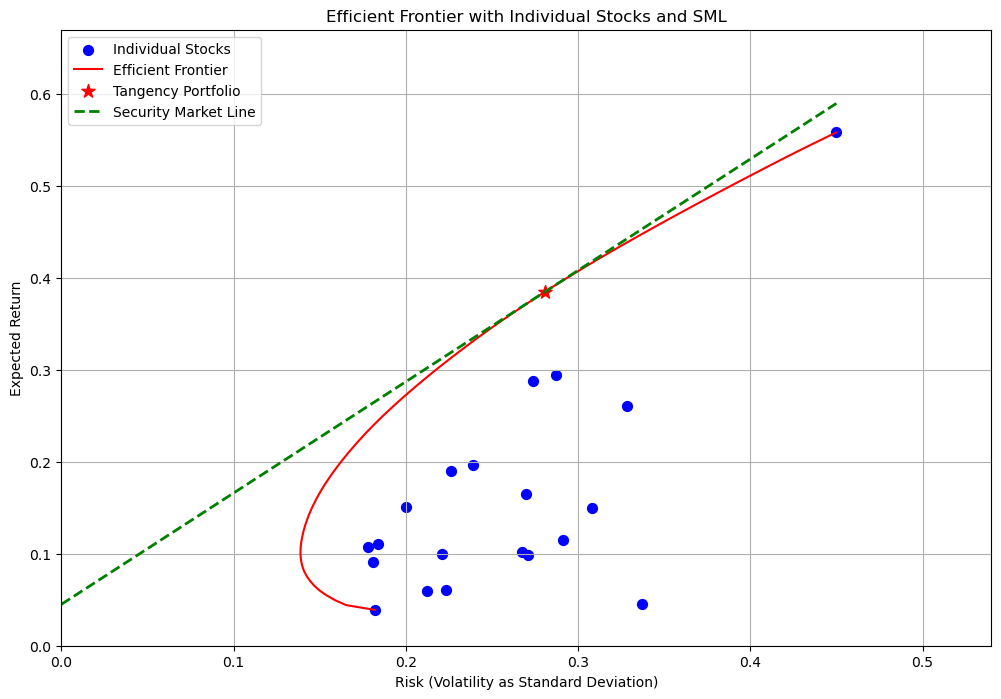

In [61]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
risk_free_rate = 0.045

portfolios = find_efficient_frontier(mean_returns, cov_matrix, np.linspace(min(mean_returns), max(mean_returns), 100))
plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, portfolios)